# An example of masterplan creation

In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from IPython.display import Image, Markdown, display

from masterplan_tools.method import MasterPlan, balance_data
from masterplan_tools.method.provision import ProvisionModel
from masterplan_tools.models import CityModel
from masterplan_tools.preprocessing import DataGetter


def pandas_to_markdown(df_or_series: pd.DataFrame | pd.Series, value_name: str | None = None) -> Markdown:
    if isinstance(df_or_series, pd.DataFrame):
        return Markdown(
            "\n".join(
                (
                    f"| {' | '.join(column for column in df_or_series.columns)} |",
                    f"| {' | '.join(('---',) * df_or_series.shape[1])} |",
                    "\n".join(
                        f"| {' | '.join(str(value) for value in values)} |" for _, values in df_or_series.iterrows()
                    ),
                )
            )
        )
    elif isinstance(df_or_series, pd.Series):
        if value_name is None:
            value_name = "value"
        return Markdown(
            "\n".join(
                (
                    f"| {df_or_series.name} | {value_name} |",
                    "| --- | --- |",
                    "\n".join(f"| {key} | {round(value)} |" for key, value in df_or_series.items()),
                )
            )
        )
    raise ValueError(f"'{df_or_series}' is neither DataFrame nor Series")

c:\masterplanning\env\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\skitl\AppData\Local\Temp\ipykernel_18620\678285079.py:3: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are u

c:\masterplanning\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### City model creation

In [2]:
# path to data
example_data_path = "./data"
# TODO: upload example data somewhere and download it in script


# load data required for blocks creation
city_geometry = gpd.read_parquet(os.path.join(example_data_path, "city_geometry.parquet"))
water_geometry = gpd.read_parquet(os.path.join(example_data_path, "water_geometry.parquet"))
roads_geometry = gpd.read_parquet(os.path.join(example_data_path, "roads_geometry.parquet"))
railways_geometry = gpd.read_parquet(os.path.join(example_data_path, "railways_geometry.parquet"))
nature_geometry_boundaries = gpd.read_parquet(os.path.join(example_data_path, "nature_geometry_boundaries.parquet"))

# load data required for service graphs creation
schools = gpd.read_parquet(os.path.join(example_data_path, "schools.parquet"))
kindergartens = gpd.read_parquet(os.path.join(example_data_path, "kindergartens.parquet"))
recreational_areas = gpd.read_parquet(os.path.join(example_data_path, "recreational_areas.parquet"))
# accessibility_matrix = pd.read_pickle(path + "accessibility_matrix.pkl")

# load data required for
buildings = gpd.read_parquet(os.path.join(example_data_path, "buildings.parquet"))
greenings = gpd.read_parquet(os.path.join(example_data_path, "greenings.parquet"))
parkings = gpd.read_parquet(os.path.join(example_data_path, "parkings.parquet"))

transport_graph = nx.read_graphml(os.path.join(example_data_path, "new_graph.graphml"))

# data loading with planning area
polygon = gpd.read_file(os.path.join(example_data_path, "polygon.geojson"))

In [3]:
# services should be specified as a dictionary
services = {"schools": schools, "kindergartens": kindergartens, "recreational_areas": recreational_areas}

In [4]:
# City data model creation
city_model = CityModel(
    services=services,
    city_geometry=city_geometry,
    water_geometry=water_geometry,
    roads_geometry=roads_geometry,
    railways_geometry=railways_geometry,
    nature_geometry_boundaries=nature_geometry_boundaries,
    # accessibility_matrix=accessibility_matrix,
    transport_graph=transport_graph,
    buildings=buildings,
    greenings=greenings,
    parkings=parkings,
)

Iterating blocks to prepare graph: 100%|██████████| 151/151 [00:00<00:00, 1228.68it/s]


#### Calculating the provision of services in blocks

In [5]:
services_prov = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    print(service_type)
    services_prov[service_type] = provision.run()

schools
Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

kindergartens
Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

recreational_areas
Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### Service provision visualization

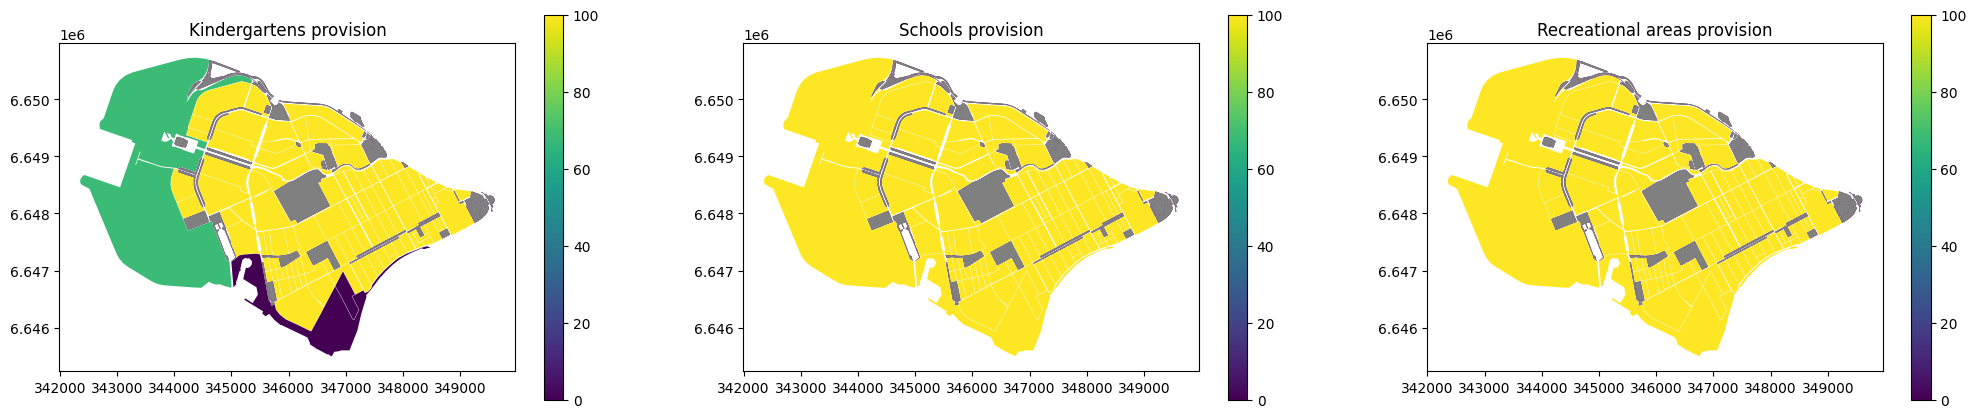

In [6]:
kindergartens_prov = services_prov["kindergartens"]
schools_prov = services_prov["schools"]
recreational_areas_prov = services_prov["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov[kindergartens_prov["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov[schools_prov["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov[recreational_areas_prov["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Selected area of the city to which the new parameters will be modelled

In [7]:
try:
    display(polygon.explore())
except:
    print("Install additional packages to get an interactive map: `pip install folium matplotlib mapclassify`")
    display(Image(filename="../img/polygon.png", embed=True))

In [8]:
block = balance_data(
    gdf=city_model.blocks_aggregated_info,
    polygon=polygon,
    school=services_prov["schools"],
    kindergarten=services_prov["kindergartens"],
    greening=services_prov["recreational_areas"],
)

In [9]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |",
        "| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in block.items()),
    )
)

pandas_to_markdown(pd.Series(block, name="Option"), "Teckno-economic indicator")

| Option | Teckno-economic indicator |
| --- | --- |
| block_id | 24 |
| area | 40 |
| current_living_area | 5 |
| current_industrial_area | 1 |
| current_population | 14424 |
| current_green_area | 1 |
| floors | 4 |
| population_unprov_schools | 0 |
| population_unprov_kindergartens | 0 |
| population_unprov_recreational_areas | 0 |

#### Modelling of new parameters for the selected area with maximisation of the number of inhabitants

In [10]:
mp = MasterPlan(
    area=block["area"],
    current_living_area=block["current_living_area"],
    current_industrial_area=block["current_industrial_area"],
    current_population=block["current_population"],
    current_green_area=block["current_green_area"],
    current_unprov_schoolkids=block["population_unprov_schools"],
    current_unprov_kids=block["population_unprov_kindergartens"],
    current_unprov_green_population=block["population_unprov_recreational_areas"],
)

updated_block = mp.optimal_solution_indicators()
updated_block["block_id"] = 24

#### Modelled block transformation requirements

In [11]:
markdown_table = "\n".join(
    (
        "| Option | Techno-economic indicator |\n| --- | --- |",
        "\n".join(f"| {key} | {round(value)} |" for key, value in updated_block.items()),
    )
)

# Markdown(markdown_table)
pandas_to_markdown(pd.Series(updated_block, name="Option"))

| Option | value |
| --- | --- |
| area | 40 |
| population | 17773 |
| b | 30 |
| green_coef_G | 9 |
| living_area | 15 |
| schools_area | 1 |
| schools_capacity | 600 |
| kindergartens_area | 0 |
| kindergartens_capacity | 0 |
| green_area | 4 |
| G_min_capacity | 6770 |
| G_max_capacity | 3385 |
| green_coef_G_capacity | 4513 |
| op_area | 0 |
| parking1_area | 3 |
| parking2_area | 2 |
| block_id | 24 |

#### Making changes based on requirements in the data model

In [12]:
services_graph = nx.Graph()
for service_type in services.keys():
    service_graph = DataGetter().prepare_graph(
        blocks=city_model.city_blocks,
        service_type=service_type,
        buildings=city_model.buildings,
        service_gdf=city_model.services_gdfs[service_type],
        updated_block_info=updated_block,
        accessibility_matrix=city_model.accessibility_matrix,
        services_graph=services_graph,
    )

city_model.services_graph = services_graph

Iterating blocks to prepare graph: 100%|██████████| 151/151 [00:00<00:00, 1229.25it/s]


#### Recalculating the provision of services to blocks

In [13]:
services_prov_nev = {}

for service_type in services.keys():
    provision = ProvisionModel(city_model=city_model, service_name=service_type)
    services_prov_nev[service_type] = provision.run()

Number of blocks with service: schools: 28
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: kindergartens: 32
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0

Number of blocks with service: recreational_areas: 151
Number of residential blocks: 114
Number of blocks total: 199
Number of blocks with an error: 0



#### New service provision visualization

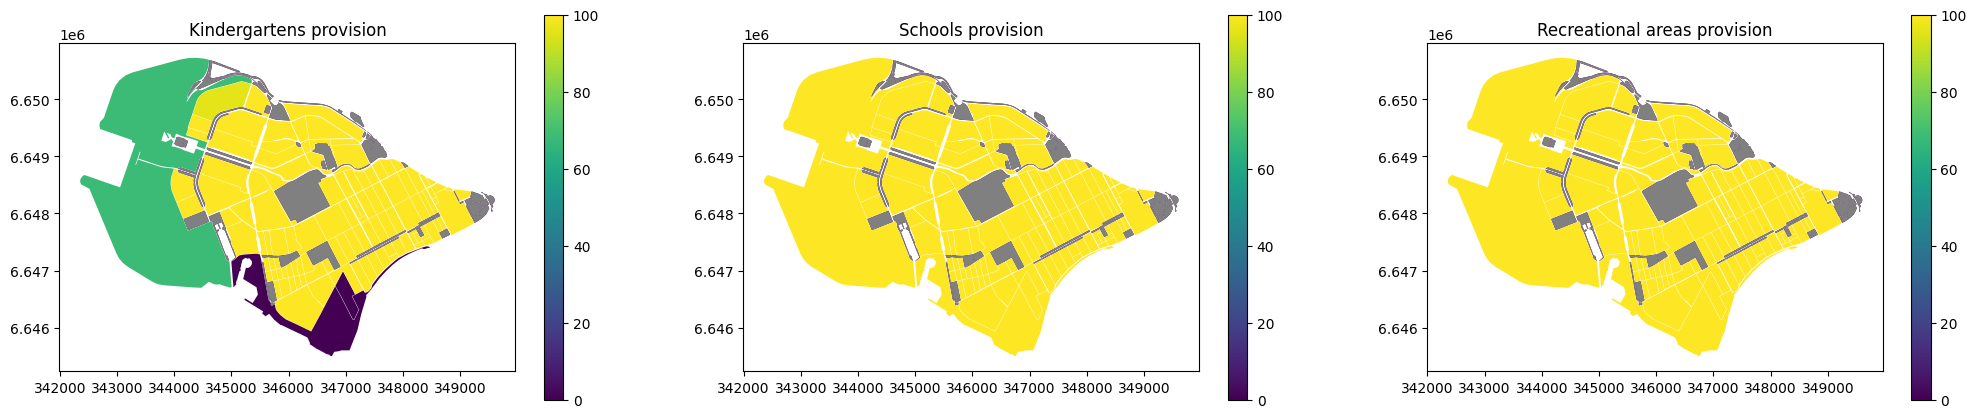

In [14]:
kindergartens_prov_nev = services_prov_nev["kindergartens"]
schools_prov_nev = services_prov_nev["schools"]
recreational_areas_prov_nev = services_prov_nev["recreational_areas"]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
kindergartens_prov_nev.plot(column="provision_kindergartens", legend=True, ax=ax1)
ax1.set_title("Kindergartens provision")
schools_prov_nev.plot(column="provision_schools", legend=True, ax=ax2)
ax2.set_title("Schools provision")
recreational_areas_prov_nev.plot(column="provision_recreational_areas", legend=True, ax=ax3)
ax3.set_title("Recreational areas provision")

kindergartens_prov_nev[kindergartens_prov_nev["population"] == 0].plot(ax=ax1, color="grey", alpha=1)
schools_prov_nev[schools_prov_nev["population"] == 0].plot(ax=ax2, color="grey", alpha=1)
recreational_areas_prov_nev[recreational_areas_prov_nev["population"] == 0].plot(ax=ax3, color="grey", alpha=1)

plt.show()

#### Comparison of service provision before and after the territory change

In [15]:
data = []
before = services_prov["kindergartens"].iloc[24]
after = services_prov_nev["kindergartens"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["schools"].iloc[24]
after = services_prov_nev["schools"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
before = services_prov["recreational_areas"].iloc[24]
after = services_prov_nev["recreational_areas"].iloc[24]
for attr in before.index:
    if attr not in ["id", "geometry", "population"]:
        data.append([attr, before[attr], after[attr]])
result = pd.DataFrame(data, columns=["Attribute", "Before", "After"])


pandas_to_markdown(result)

| Attribute | Before | After |
| --- | --- | --- |
| provision_kindergartens | 100 | 96 |
| population_prov_kindergartens | 879 | 1047 |
| population_unprov_kindergartens | 0 | 36 |
| population | 14424 | 17773 |
| provision_schools | 100 | 100 |
| population_prov_schools | 1730 | 2132 |
| population_unprov_schools | 0 | 0 |
| provision_recreational_areas | 100 | 100 |
| population_prov_recreational_areas | 14424 | 17772 |
| population_unprov_recreational_areas | 0 | 0 |